# Kaggle Bike Share Competition 

We examine and fit models to the data found here: https://www.kaggle.com/c/bike-sharing-demand

The notebook is organized into the following sections:
- Data Preparation
- Data Visualization
- Multiple Linear Regression (MLR) Model
- XGBoost Model

Data Notes:
You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

Date range for training data: Jan 1, 2011 to Dec 12, 2012 

datetime - hourly date + timestamp <br>
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter <br>
holiday - whether the day is considered a holiday<br>
workingday - whether the day is neither a weekend nor holiday<br>
weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy <br>
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist <br>
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds <br>
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog <br>
temp - temperature in Celsius<br>
atemp - "feels like" temperature in Celsius<br>
humidity - relative humidity<br>
windspeed - wind speed<br>
casual - number of non-registered user rentals initiated<br>
registered - number of registered user rentals initiated<br>
count - number of total rentals<br>

Notation notes: think of variable 'data' as the raw data table

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import xgboost as xgb

C:\Users\dhamm\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data Preparation


In [2]:
data = pd.read_csv("train.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB



### Cleaning up the date format:
- convert to datetime
- change index
- add date col
- add y,m,d,hr cols
- drop datetime col

In [3]:
data['datetime'] = pd.to_datetime(data.datetime)
data.index = data.datetime
data['date'] = data['datetime'].dt.date

data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour
data = data.drop(["datetime"], axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 16 columns):
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
date          10886 non-null object
year          10886 non-null int64
month         10886 non-null int64
day           10886 non-null int64
hour          10886 non-null int64
dtypes: float64(3), int64(12), object(1)
memory usage: 1.4+ MB


### Change to categorical variables

In [4]:
cat_vars = ["season","holiday","workingday","weather","hour","year","month","day"]
for var in cat_vars:
    data[var] = data[var].astype("category")

# Data Visualization
### Histogram of Count 
Transforming the count data gives a much nicer (more Gaussian) distribution which will be advantageous for the MLR model.


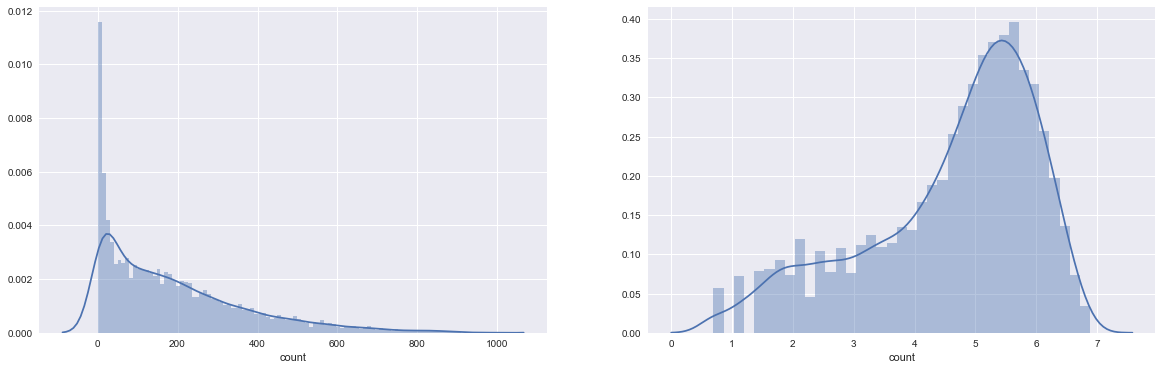

In [5]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(20, 6)
sns.distplot(data['count'], bins=100, ax=axes[0])
sns.distplot(np.log1p(data['count']),ax=axes[1])
plt.show()  

### Visualizing the Weather Category

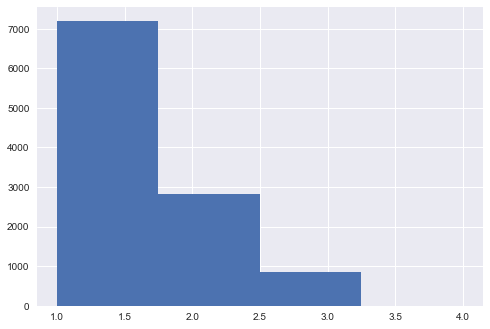

In [6]:
plt.hist(data['weather'], bins = 4)
plt.show()

In [7]:
data.groupby('weather').count() 

,season,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour
weather,,,,,,,,,,,,,,,
1,7192,7192,7192,7192,7192,7192,7192,7192,7192,7192,7192,7192,7192,7192,7192
2,2834,2834,2834,2834,2834,2834,2834,2834,2834,2834,2834,2834,2834,2834,2834
3,859,859,859,859,859,859,859,859,859,859,859,859,859,859,859
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


Interesting... only one hour from all the data is classified as 4 for the weather
Lets drop the weather category 4 entry since this outlier data is as equally unlikely to show up in the test cases.


In [8]:
data = data[data.weather != 4]

### Workday vs Holiday vs Weekend Count Means

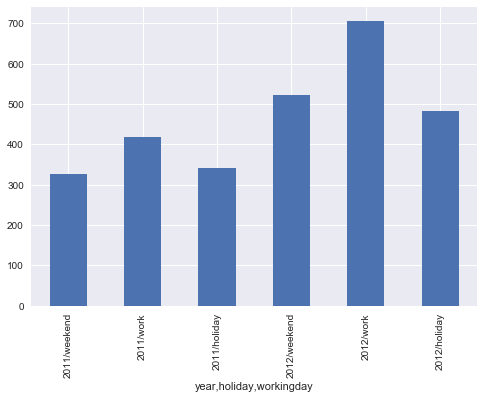

In [9]:
fig.set_size_inches(10,6)
whw = data.groupby(['date', 
                    'holiday', 
                    'workingday', 
                    'year'])['count'].max().groupby(['year','holiday', 'workingday']).mean()
                                                                    
ax = whw.plot(kind = 'bar')
ax.set_xticklabels(['2011/weekend', '2011/work', '2011/holiday', '2012/weekend', '2012/work', '2012/holiday'])
plt.show()


### Year and Season vs Mean Daily Maximum Count

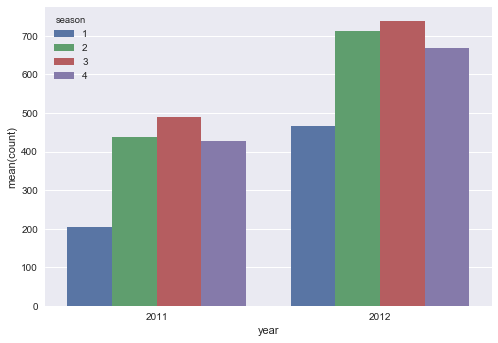

In [10]:
seasonal_avgs = data.groupby([data.date, 
                              data.season, data.year])['count'].max().groupby(['year', 'season']).mean()
seasonal_avgs = pd.DataFrame(seasonal_avgs).reset_index()
sns.barplot(data = seasonal_avgs, x = 'year', y ='count', hue = 'season')

#ew_labels = ['Spring', 'Summer', 'Fall', 'Winter']
#for t, l in zip(p._legend.texts, new_labels): t.set_text(l)
sns.plt.show()

### Mean Count over the period of a Day:

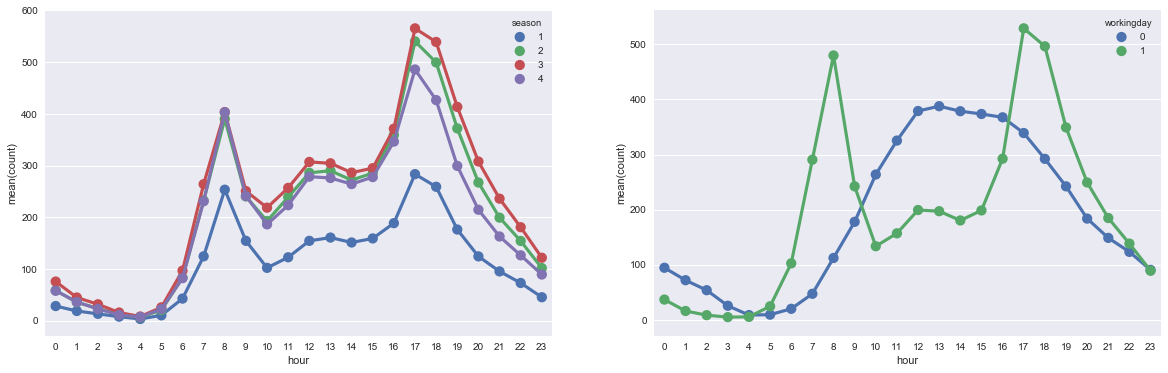

In [11]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(20, 6)

#by season
by_hour = data.groupby(['hour', 'season'])['count'].mean()
by_hour = pd.DataFrame(by_hour).reset_index()
sns.pointplot(data=by_hour, x='hour',y='count',hue='season', ax=axes[0])

#by type of day
by_day = data.groupby(['hour', 'workingday'])['count'].mean()
by_day = pd.DataFrame(by_day).reset_index()
sns.pointplot(data=by_day, x='hour',y='count', hue='workingday',ax=axes[1])

plt.show()

### Examining the effect of windspeed

There is a discontinuity in the data with windspeeds less than 5 mph being recorded as 0. The correlation coefficient analysis below also shows a weak correlation (0.1)

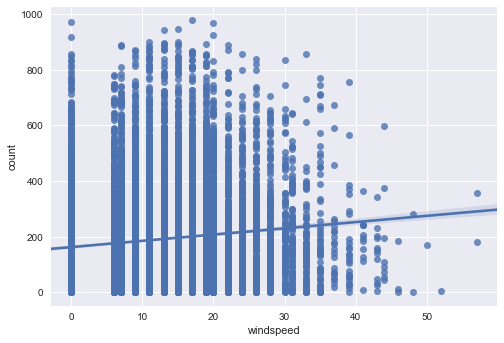

In [12]:
sns.regplot(x="windspeed", y="count", data=data)
plt.show()

### General Correlation Coefficient analysis
Given so many datapoints (~10^4), p-values for pearson correlation coeff are going to be <<<0.05


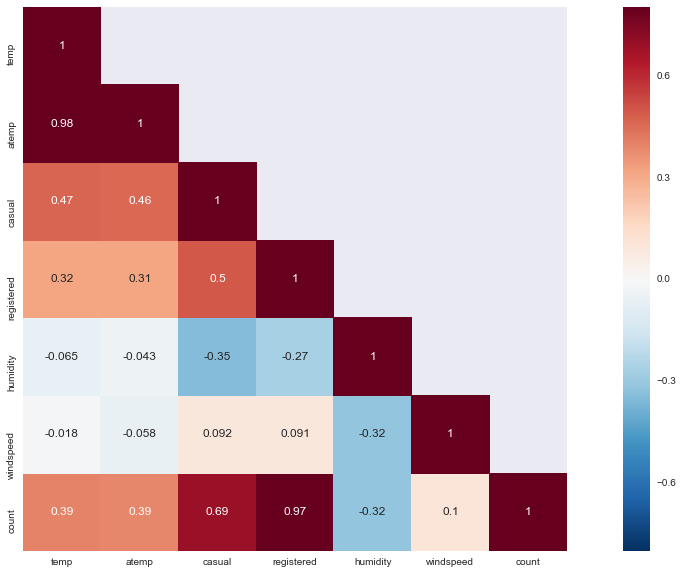

In [13]:
corMatt = data[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
mask = np.array(corMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corMatt, mask=mask,vmax=.8, square=True,annot=True)
plt.show()

Let's check a few p-values to be sure


In [14]:
out = []
out.append(sp.stats.pearsonr(data['temp'], data.atemp))
out.append(sp.stats.pearsonr(data['windspeed'], data['count']))
out.append(sp.stats.pearsonr(data['humidity'], data['count']))
out

[(0.98494541183141238, 0.0),
 (0.10136116271515364, 2.9408867450724613e-26),
 (-0.31737718341424787, 3.0141324235680057e-253)]

#### Analysis:
'atemp' and temp are highly correlated (0.98) hence we will drop atemp from the MLR model.
Additionally there are many 0 values for windspeed and this predictor has a low correlation coefficient.

Hence we will drop atemp and windspeed from the MLR model

### Pair plot 
Confirm coefficient analysis and catch any other irregularities

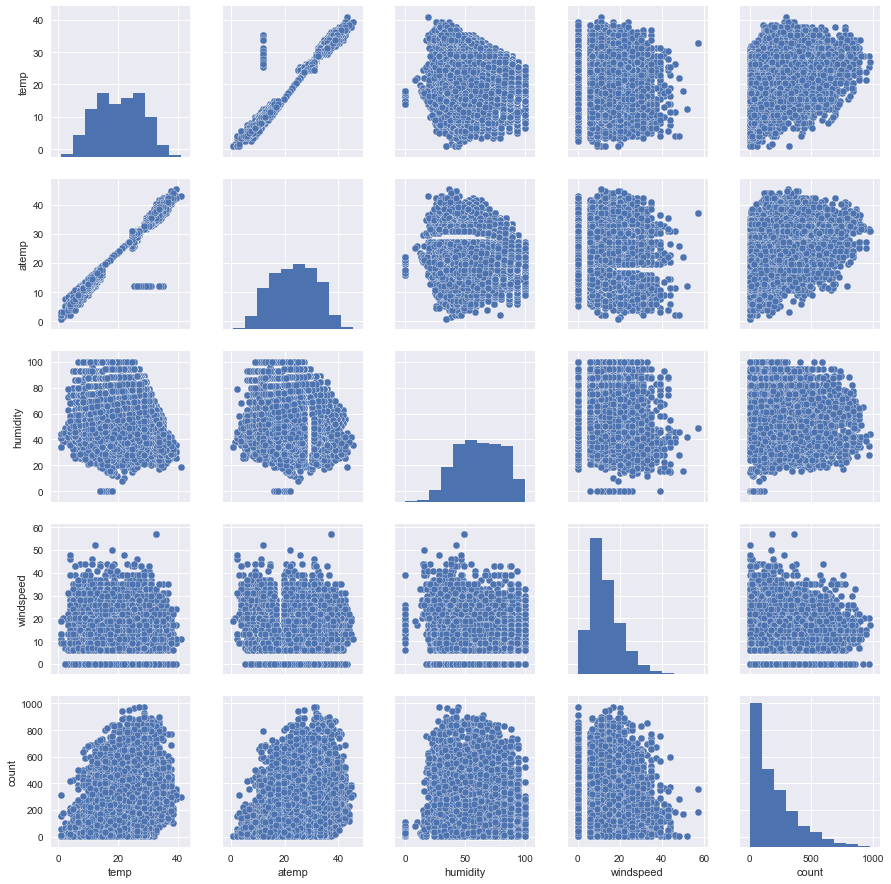

In [15]:
num_vars = ['temp', 'atemp', 'humidity','windspeed', 'count']
sns.pairplot(data, vars = num_vars)
plt.show()

### Analysis:

Weird data with atemp ~ 11C and temp in the range [25,35] C... <br>
Other data look like unorganized blobs which means they're weakly/un correlated which is good for our MLR model


# Multiple Linear Regression (MLR) Model
## Dropping variables

In [16]:
drop_vars = ['windspeed', 'atemp', 'date','casual','registered']
dataDropped = data.drop(drop_vars, axis = 1)
dataDropped.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10885 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
season        10885 non-null category
holiday       10885 non-null category
workingday    10885 non-null category
weather       10885 non-null category
temp          10885 non-null float64
humidity      10885 non-null int64
count         10885 non-null int64
year          10885 non-null category
month         10885 non-null category
day           10885 non-null category
hour          10885 non-null category
dtypes: category(8), float64(1), int64(2)
memory usage: 747.8 KB


#### Create training and test set
We dummy encode categorical variables for increased model performance and split data into train/test sets (80%/20%). Note that we transform the reponse ('count') by a log function to increase model performance (see histogram above).

In [17]:
from sklearn.model_selection import train_test_split

reg_cat_vars = ['season','weather','hour','year','month','day']
cat_dummies = pd.get_dummies(dataDropped[reg_cat_vars], drop_first = True)
cat_dummies = cat_dummies.drop(['weather_4'], axis=1) #only 1 data point had category 4 weather

dataReg = pd.concat([dataDropped[['temp','humidity','holiday','workingday']], cat_dummies], axis=1)

X_train, X_test, y_train, y_test = train_test_split(dataReg, dataDropped['count'], test_size=0.2, random_state=0)

y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

In [18]:
def rmsle(y, y_preds): #error function defined in the competition
    y = np.exp(y)
    y_preds = np.exp(y_preds)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_preds]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

### Train Model

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

linModel = LinearRegression()

#train the model
linModel.fit(X = X_train, y = y_train)

# Make predictions
preds = linModel.predict(X = X_train)
print ("RMSLE Value For Linear Regression: ", rmsle(y_train,preds))

('RMSLE Value For Linear Regression: ', 0.55798192994045681)


Now we test our model on our training set

In [20]:
# Make predictions
preds = linModel.predict(X = X_test)
print ("RMSLE Value For Linear Regression: ", rmsle(y_test,preds))

('RMSLE Value For Linear Regression: ', 0.55425647751557938)


# XGBoost Model

Create training and test set with dummy and one-hot-encoding. XGBoost is very "robust to correlated variables" so no need to remove certain vars.


In [21]:
cat_vars = cat_vars.remove("day") #won't be using day predictor for XGB since 20th-30th doesn't exist in training data

dummy_vars = pd.get_dummies(data[cat_vars], drop_first = True)
dummy_vars = dummy_vars.drop(['weather_4'], axis=1) #only 1 data point had category 4 weather
dummyData = pd.concat([data[['temp','atemp','humidity','windspeed']], dummy_vars], axis=1)

one_hot_vars = pd.get_dummies(data[cat_vars], drop_first = False)
one_hot_vars = one_hot_vars.drop(['weather_4'], axis=1) #only 1 data point had category 4 weather
oneHotData = pd.concat([data[['temp','atemp','humidity','windspeed']], one_hot_vars], axis=1)


dummy_X_train, dummy_X_test, dummy_y_train, dummy_y_test = train_test_split(dummyData, np.log1p(data['count']), 
                                                                            test_size=0.2, random_state=0)
oh_X_train, oh_X_test, oh_y_train, oh_y_test = train_test_split(oneHotData, np.log1p(data['count']), 
                                                                test_size=0.2, random_state=0)

In [22]:
from xgboost.sklearn import XGBRegressor
from sklearn import metrics
from sklearn.grid_search import GridSearchCV

def trainModel(X_train, X_test, y_train, y_test, model, erounds):
    xtrain = X_train
    ytrain = y_train
    xtest = X_test
    ytest = y_test

    model.fit(xtrain, ytrain, eval_set=[(xtrain, ytrain),(xtest,ytest)], early_stopping_rounds=erounds, 
              eval_metric = 'rmse')
    return model

def gridSearch(search_params, model, X_train, y_train):
    search = GridSearchCV(estimator = model, param_grid = search_params, 
                          scoring = 'neg_mean_squared_error', n_jobs=4, iid=False, cv=5)
    search.fit(X_train, y_train)
    print(search.grid_scores_, search.best_params_, search.best_score_)


Find optimal params and fit model for one hot encoding (see XGBoost Hyper-parameter tuning notebook for details)

In [23]:
%%capture #suppress output
'''model_init = XGBRegressor(learning_rate = 0.2,
               n_estimators=300,
               max_depth=8,
               min_child_weight=6,
               gamma=0.4,
               subsample=0.8,
               colsample_bytree=0.8,
               objective= 'reg:linear',
               scale_pos_weight=1,
               silent = True,
               seed=1)
m = trainModel(oh_X_train, oh_X_test, oh_y_train, oh_y_test, model_init, 50)
'''

In [24]:
%%capture
'''
s1params = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(2,10,2)
}

gridSearch(s1params, m, oh_X_train, oh_y_train)
'''

In [25]:
%%capture
'''
s2params = {
    'max_depth':[4,5,6],
    'min_child_weight':[3,4,5,6,7]
}
gridSearch(s2params, m, oh_X_train, oh_y_train)

'''

In [26]:
%%capture
'''
model_2 = XGBRegressor(learning_rate = 0.2,
               n_estimators=300,
               max_depth=5,
               min_child_weight=5,
               gamma=0,
               subsample=0.8,
               colsample_bytree=0.8,
               objective= 'reg:linear',
               scale_pos_weight=1,
               silent = True,
               seed=1)
m2 = trainModel(oh_X_train, oh_X_test, oh_y_train, oh_y_test, model_2, 50)
'''

... 
...

In [27]:
model_4 = XGBRegressor(learning_rate = 0.2,
               n_estimators=300,
               max_depth=5,
               min_child_weight=5,
               gamma=0.4,
               subsample=0.7,
               colsample_bytree=0.6,
               objective= 'reg:linear',
               scale_pos_weight=1,
               silent = False,
               seed=1)
m4 = trainModel(oh_X_train, oh_X_test, oh_y_train, oh_y_test, model_4, 50)

[0]	validation_0-rmse:3.52768	validation_1-rmse:3.54694
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:2.88767	validation_1-rmse:2.90544
[2]	validation_0-rmse:2.39477	validation_1-rmse:2.40927
[3]	validation_0-rmse:1.99605	validation_1-rmse:2.01058
[4]	validation_0-rmse:1.69914	validation_1-rmse:1.71118
[5]	validation_0-rmse:1.46838	validation_1-rmse:1.48064
[6]	validation_0-rmse:1.27982	validation_1-rmse:1.29223
[7]	validation_0-rmse:1.14839	validation_1-rmse:1.16333
[8]	validation_0-rmse:0.990363	validation_1-rmse:1.00496
[9]	validation_0-rmse:0.873934	validation_1-rmse:0.888688
[10]	validation_0-rmse:0.816538	validation_1-rmse:0.832231
[11]	validation_0-rmse:0.773185	validation_1-rmse:0.789821
[12]	validation_0-rmse:0.704621	validation_1-rmse:0.722349
[13]	validation_0-rmse:0.656333	validation_1-rmse:0.673894
[14]	validation_0-rmse:0.614226	validation

[137]	validation_0-rmse:0.267283	validation_1-rmse:0.33514
[138]	validation_0-rmse:0.266832	validation_1-rmse:0.334736
[139]	validation_0-rmse:0.26605	validation_1-rmse:0.334646
[140]	validation_0-rmse:0.265395	validation_1-rmse:0.333951
[141]	validation_0-rmse:0.264937	validation_1-rmse:0.333421
[142]	validation_0-rmse:0.264719	validation_1-rmse:0.333303
[143]	validation_0-rmse:0.264303	validation_1-rmse:0.333518
[144]	validation_0-rmse:0.263989	validation_1-rmse:0.333119
[145]	validation_0-rmse:0.263349	validation_1-rmse:0.332652
[146]	validation_0-rmse:0.262951	validation_1-rmse:0.33239
[147]	validation_0-rmse:0.262783	validation_1-rmse:0.332348
[148]	validation_0-rmse:0.262741	validation_1-rmse:0.332332
[149]	validation_0-rmse:0.262629	validation_1-rmse:0.332444
[150]	validation_0-rmse:0.262478	validation_1-rmse:0.332648
[151]	validation_0-rmse:0.261949	validation_1-rmse:0.332274
[152]	validation_0-rmse:0.261482	validation_1-rmse:0.332435
[153]	validation_0-rmse:0.261286	validation

[275]	validation_0-rmse:0.24022	validation_1-rmse:0.32614
[276]	validation_0-rmse:0.240156	validation_1-rmse:0.326288
[277]	validation_0-rmse:0.240155	validation_1-rmse:0.32629
[278]	validation_0-rmse:0.240043	validation_1-rmse:0.326305
[279]	validation_0-rmse:0.239993	validation_1-rmse:0.326099
[280]	validation_0-rmse:0.239786	validation_1-rmse:0.326057
[281]	validation_0-rmse:0.239599	validation_1-rmse:0.326091
[282]	validation_0-rmse:0.239599	validation_1-rmse:0.326098
[283]	validation_0-rmse:0.239485	validation_1-rmse:0.325773
[284]	validation_0-rmse:0.239399	validation_1-rmse:0.325742
[285]	validation_0-rmse:0.239399	validation_1-rmse:0.325737
[286]	validation_0-rmse:0.239315	validation_1-rmse:0.325854
[287]	validation_0-rmse:0.239159	validation_1-rmse:0.326093
[288]	validation_0-rmse:0.239048	validation_1-rmse:0.326053
[289]	validation_0-rmse:0.239048	validation_1-rmse:0.326047
[290]	validation_0-rmse:0.238856	validation_1-rmse:0.326054
[291]	validation_0-rmse:0.2388	validation_1

In [28]:
# Cross validate
preds = m4.predict(oh_X_test)
print ("RMSLE Value For XGB: ", rmsle(oh_y_test,preds))

('RMSLE Value For XGB: ', 0.3065326475085185)


# Predicting and writing to file

In [29]:
testdata = pd.read_csv("test.csv")
testdata.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [32]:
%%capture
'''
testdata['datetime'] = pd.to_datetime(testdata.datetime)
testdata['year'] = testdata['datetime'].dt.year
testdata['month'] = testdata['datetime'].dt.month
testdata['day'] = testdata['datetime'].dt.day
testdata['hour'] = testdata['datetime'].dt.hour

cat_vars = ["season","holiday","workingday","weather","hour","year","month","day"]
for var in cat_vars:
    testdata[var] = testdata[var].astype("category")

test_cat_vars = pd.get_dummies(testdata[cat_vars], drop_first = False)

#test_cat_vars = one_hot_vars.drop(['weather_4'], axis=1) #only 1 data point had category 4 weather
oneHotTest = pd.concat([testdata[['temp','atemp','humidity','windspeed']], test_cat_vars], axis=1)

predictions = m4.predict(oneHotTest)
predictions = np.exp(predictions)

result = pd.concat([testdata['datetime'], predictions], axis=1)
result.head()
'''